# Validate (randomly!)
In this script, validation is performed randomly.  
To do this, a random 10% of data is used for testing, and the remaining 90% is used for training.  

Would expect the scores to be somewhat similar to those found in cross-validation

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
import time as time
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
# Machine learning packages
# import xgboost as xgb

# Custom function for neg_mean_absolute_percentage_error
def neg_mean_absolute_percentage_error(y_true, y_pred):
    return -100 * np.mean(np.abs((y_true - y_pred) / y_true))

from Functions import *

### Get the necessary data
#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes)

In [2]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

#### Drop one version of the time variables (either cyclical or dummy versions)

In [3]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

#### Delete the year variable

In [4]:
del Xfull['year']

#### Get the sensor locations (this is needed if splitting the data spatially in cross validation)

In [5]:
melbourne_sensors = pd.read_csv("../Data/FootfallData/melbourne_locations.csv")

#### Get as series the sensor ids and datetimes

In [6]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
datetimes = pd.read_csv(input_csv)['datetime']

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [7]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

### Set up model pipelines

In [8]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])

In [9]:
models_dict = {"rf_regressor":rf_model_pipeline}

## Cross validation manually 

### Randomly select 90% of rows

In [11]:
ninety_percent = Xfull.sample(n = int(len(Xfull)*0.9))
train_index = ninety_percent.index.tolist()
test_index=Xfull.index.tolist()
test_index = list(set(test_index) - set(train_index))

## Run the cross validation
Loop through each cluster, and set that cluster as testing and the rest as training

In [12]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

In [13]:
start = time()

# Get train and testing data for this fold
print(f"train index: {len(train_index)}")
print(f"test index: {len(test_index)}")
print(f"percentage of data used as testing: {round(len(test_index)/len(train_index)*100,1)}")
X_train, X_test = Xfull.iloc[train_index], Xfull.iloc[test_index]
y_train, y_test = Yfull[train_index], Yfull[test_index]
# Fit the model on the training data
rf_model_pipeline.fit(X_train, y_train)
# Use it to make predictions on the testing data, and store these
y_pred = rf_model_pipeline.predict(X_test)
predicted_values.append(y_pred)
# Store the datetimes
datetimes_used.append(datetimes[train_index])
# Store the actual values for the testing data
observed_values.append(y_test)
# Calculate the error metrics for this fold and append to the scores lists
mae_scores.append(mean_absolute_error(y_test, y_pred))
r2_scores.append(r2_score(y_test, y_pred))
rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
neg_mae_scores = [-score for score in mae_scores]       

end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

train index: 3716173
test index: 412909
percentage of data used as testing: 11.1
Ran cross_val_predict in 27 minutes


In [ ]:
# # len(Xfull['Cluster_number'].unique())
# datetimes_used = datetimes_used[6:]
# mae_scores = mae_scores[6:]
# r2_scores = r2_scores[6:]
# rmse_scores = rmse_scores[6:]
# neg_mae_scores = neg_mae_scores[6:]
# observed_values = observed_values[6:]

## Scores (across all cross validation runs)

In [14]:
print(f"Mean absoloute error: {mae_scores[0]}")
print(f"Mean R2: {r2_scores[0]}")
print(f"Mean RMSE: {rmse_scores[0]}")

Mean absoloute error: 73.04703772501931
Mean R2: 0.9133015158109884
Mean RMSE: 145.58641095908948


## Plot Predicted vs Observed (averaged across all CV runs)

In [ ]:
# predicted_values_all = []
# observed_values_all= []
# for i in range(len(predicted_values)):
#     for j in range(len(predicted_values[i])):
#         observed_values_all.append(observed_values[i][j])
#         predicted_values_all.append(predicted_values[i][j])

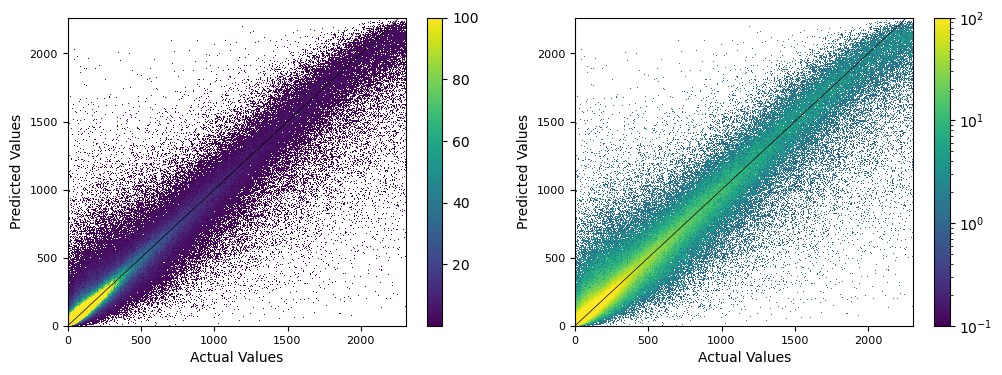

In [15]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], observed_values[0], predicted_values[0], 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], observed_values[0], predicted_values[0], 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

## Plot predicted vs observed (for each spatial split iteration separately)

In [ ]:
fig, axs = plt.subplots(ncols=4,nrows=2, figsize = (20,8), sharey=True)

for i, ax in enumerate(axs.flat):
    if i != 7:
        using_datashader(ax, observed_values[i], predicted_values[i], 'linear')
        ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
        ax.set_ylabel("Predicted Values", size=15)
        ax.set_xlabel("Actual Values", size=15)
        ax.tick_params(axis='both', which='major', labelsize=13)
    if i ==7:
        ax.axis('off')